A --> motos
el resto coches... quiza deberiamos hacer algo distinto para las motos!!!
Hay coches amarillos que no están en el dataset, por ejemplo!

In [1]:
import tensorflow

In [5]:
from dl_model_unet import dataset
#reload(dataset)

import numpy as np
import pandas as pd

max_shape = 512
image_index = 10
test_images = 10
bsize = 5

labels_data = pd.read_csv('data/trainingObservations.csv')
data = dataset.get_labels(labels_data, {'A':'Moto', 'B':'Car', 'C':'Car', 'D':'Car', 'E':'Car', 'F':'Car', 'G':'Car', 'H':'Car', 'I':'Car'})    

cases = list(data.keys())
np.random.shuffle(cases)
train_cases, test_cases = cases[test_images:], cases[:test_images]
train_generator = dataset.chunk(train_cases, data, bsize, max_shape)
test_generator = dataset.chunk(test_cases, data, bsize, max_shape)

#for x,y in train_generator:
#    print x.shape, y.shape

In [ ]:
from keras.optimizers import Adam
from dl_networks import unet
import keras.backend as K
from keras import backend as K


def max_pred(y_true, y_pred):
    return K.max(y_pred)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


model = unet.ThickUNET(input_shape=(3,max_shape,max_shape), activation='relu').model
model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=['accuracy',max_pred])
# logging.info('Loading exiting model...')
# model.load_weights(OUTPUT_MODEL)



In [ ]:
model.fit_generator(
                    generator=train_generator,
                    samples_per_epoch=50,  # make it small to update TB and CHECKPOINT frequently
                    nb_epoch=3000,
                    verbose=1,
                    #class_weight={0:1., 1:4.},
                    #callbacks=[tb, model_checkpoint],
                    validation_data=test_generator,  # TODO: is_training=False
                    nb_val_samples=2,
                    max_q_size=30,
                    nb_worker=1)  # a locker is needed if increased the number of parallel workers



## KNN

In [108]:
from dl_model_unet import dataset
labels_data = pd.read_csv('data/trainingObservations.csv')
data = dataset.get_labels(labels_data, {'A':'Moto', 'B':'Car', 'C':'Car', 'D':'Car', 'E':'Car', 'F':'Car', 'G':'Car', 'H':'Car', 'I':'Car'})    

In [109]:
data_to_load = 'TQ2379_0_0'
coords = data[data_to_load]['Car']
im = dataset.load_image(data_to_load)

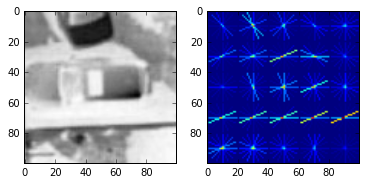

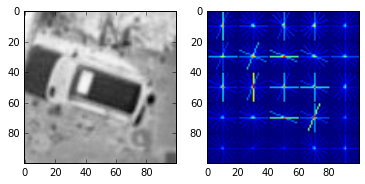

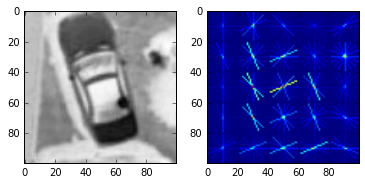

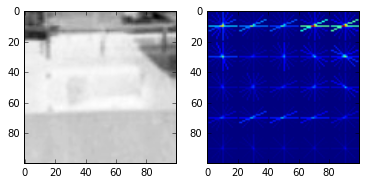

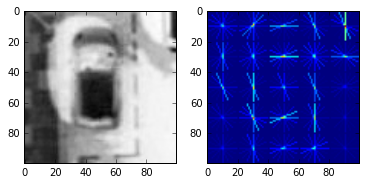

In [110]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from skimage import filters
from pylab import *

def show_segmentation(car):
    dbs = KMeans(n_clusters=5)
    s = dbs.fit_predict(car.reshape([100*100,3]))
    figure()
    subplot(121); imshow(s.reshape([100,100]))
    subplot(122); imshow(car)

def show_segmentation_2(car):
    img = car.mean(axis=2)
    im = filters.gaussian_filter(img, sigma=l / (4. * 3))
    blobs = im > im.mean()
    from skimage import measure
    blobs_labels = measure.label(blobs)
    figure(); subplot(121); imshow(car, cmap = cm.Greys); subplot(122); imshow(blobs_labels, cmap = cm.Greys)

import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import color, exposure

def plotHog(image):

    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(20, 20), cells_per_block=(1, 1), visualise=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image)#, in_range=(0, 0.02))

    figure();subplot(121);imshow(image, cmap = cm.Greys);subplot(122);imshow(hog_image_rescaled)
    
data_to_load = 'TQ2379_0_0'
coords = data[data_to_load]['Car']
im = dataset.load_image(data_to_load)    

for coords_i in range(len(coords)):
    car = im[coords[coords_i][1]-50:coords[coords_i][1]+50,coords[coords_i][0]-50:coords[coords_i][0]+50]
    plotHog(car.max(axis=2))#.mean(axis=2))

In [120]:
from sklearn.feature_extraction import image as sklearn_image
patches = sklearn_image.extract_patches_2d(car, [10,10])
(car == sklearn_image.reconstruct_from_patches_2d(patches, car.shape)).all()

True